# Clustering: in order to get a better understanding of the data collected, this notebook runs a clustering script over the dataset collected. 
# For robustness, we first reduce the vector dimensionality using UMAP for robustness. 
# We use DBSCAN because we do not know how many clusters there are in the data, we expect to find irregularly shaped clusters and DBSCAN filters out noise. 
# Finally, we apply topic interpretation via BERTopic to find the semantic topics for each cluster. We use BERTopic because it fits our datasize and works better with shorter texts. 
# After the clusters are made and topics generated, we manually delete the topics from the database that are not necessary for the final bot (mostly related to advertisements)
 

PINECONE_API_KEY is set successfully.
STEP 1: Retrieving vectors from Pinecone
Fetching 741 vectors from Pinecone...


Fetching batches: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Successfully retrieved 741 vectors
Vectors saved locally to /tmp/rizzbot_data/full_vectors.pkl

STEP 2: Performing clustering pipeline
Starting clustering pipeline...


2025-06-30 17:10:23,697 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-30 17:10:24,514 - BERTopic - Dimensionality - Completed ✓
2025-06-30 17:10:24,515 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-30 17:10:24,675 - BERTopic - Cluster - Completed ✓
2025-06-30 17:10:24,676 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-30 17:10:25,326 - BERTopic - Representation - Completed ✓
2025-06-30 17:10:25,328 - BERTopic - Topic reduction - Reducing number of topics
2025-06-30 17:10:25,347 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-30 17:10:25,900 - BERTopic - Representation - Completed ✓
2025-06-30 17:10:25,902 - BERTopic - Topic reduction - Reduced number of topics from 66 to 54
2025-06-30 17:10:26,417 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the mod

BERTopic model saved to /tmp/rizzbot_data/bertopic_model
Clustered results saved locally

STEP 3: Visualizing clusters
Visualization saved to /tmp/rizzbot_data/cluster_visualization.png


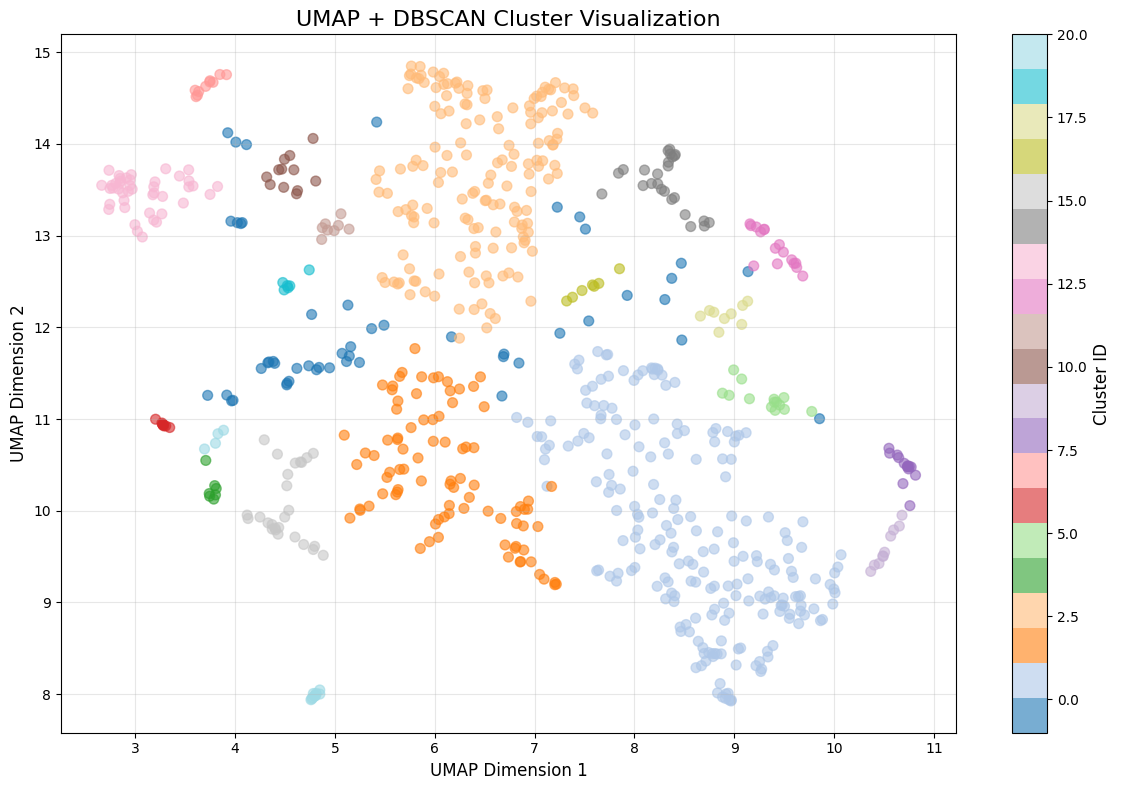


STEP 4: Saving clusters to Pinecone
Saving 741 clustered vectors to Pinecone index 'rizzbot-clusters'...


Upserting clusters: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]

Clustering results saved to Pinecone successfully!

CLUSTERING SUMMARY
Total vectors processed: 741
Number of clusters found: 22
Noise points (cluster -1): 32

Cluster sizes:
  Noise: 32 points
  Cluster 0: 19 points
  Cluster 1: 214 points
  Cluster 2: 89 points
  Cluster 3: 158 points
  Cluster 4: 7 points
  Cluster 5: 14 points
  Cluster 6: 8 points
  Cluster 7: 10 points
  Cluster 8: 14 points
  Cluster 9: 10 points
  Cluster 10: 12 points
  Cluster 11: 8 points
  Cluster 12: 16 points
  Cluster 13: 43 points
  Cluster 14: 25 points
  Cluster 15: 26 points
  Cluster 16: 7 points
  Cluster 17: 9 points
  Cluster 18: 6 points
  Cluster 19: 4 points
  Cluster 20: 10 points

Clustering pipeline completed successfully!


In [8]:
import pinecone
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import umap
from pinecone import Pinecone
from sklearn.cluster import DBSCAN
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv
import json
from pathlib import Path

# Load environment variables
_ = load_dotenv(find_dotenv())
PINE_CONE_API_KEY = os.getenv("PINECONE_API_KEY")

if not PINE_CONE_API_KEY:
    import getpass
    PINE_CONE_API_KEY = getpass.getpass("Enter your PINECONE_API_KEY: ")
    os.environ["PINECONE_API_KEY"] = PINE_CONE_API_KEY

if not PINE_CONE_API_KEY:
    raise ValueError("PINECONE_API_KEY is not set in the environment variables.")
else:
    print("PINECONE_API_KEY is set successfully.")

# Connect to Pinecone
pc = Pinecone(api_key=PINE_CONE_API_KEY)
source_index = pc.Index("rizzbot")
output_index = pc.Index("rizzbot-clusters")

def retrieve_vectors_by_id_range(index, start_id=1, end_id=741, batch_size=100):
    vector_ids = [f"emb-{i:04d}" for i in range(start_id, end_id + 1)]
    all_ids, all_embeddings, all_texts = [], [], []

    print(f"Fetching {len(vector_ids)} vectors from Pinecone...")

    for i in tqdm(range(0, len(vector_ids), batch_size), desc="Fetching batches"):
        batch_ids = vector_ids[i:i + batch_size]
        try:
            response = index.fetch(ids=batch_ids)
            for vector_id, vector_data in response['vectors'].items():
                all_ids.append(vector_id)
                all_embeddings.append(vector_data['values'])
                metadata = vector_data.get('metadata', {})
                text = (
                    metadata.get('full_text', '') or metadata.get('text', '') or 
                    metadata.get('content', '') or metadata.get('document', '') or 
                    metadata.get('chunk', '') or metadata.get('transcript', '') or 
                    str(metadata.get('s3_key', '')) or ''
                )
                all_texts.append(text)
        except Exception as e:
            print(f"Error fetching batch {i//batch_size + 1}: {e}")
            continue

    print(f"Successfully retrieved {len(all_ids)} vectors")
    return pd.DataFrame({"id": all_ids, "text": all_texts, "embedding": all_embeddings})

def perform_clustering_pipeline(df):
    print("Starting clustering pipeline...")
    embeddings = np.vstack(df['embedding'].values)
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embedding_2d = reducer.fit_transform(embeddings)

    dbscan = DBSCAN(eps=0.3, min_samples=5)
    labels = dbscan.fit_predict(embedding_2d)

    df = df.copy()
    df['cluster'] = labels
    df['x'] = embedding_2d[:, 0]
    df['y'] = embedding_2d[:, 1]

    text_data = df['text'].fillna('').astype(str)
    if any('rizzbot/Transcripts/' in text for text in text_data[:10]):
        print("Detected S3 keys instead of actual text content. Using cluster-based topics.")
        df['topic_num'] = df['cluster']
        df['topic_score'] = 1.0
        df['topic_id'] = df['topic_num']
    else:
        non_empty_texts = [text for text in text_data if text.strip()]
        if len(non_empty_texts) >= 10:
            try:
                embeddings_for_topic = np.vstack(df['embedding'].values)
                vectorizer_model = CountVectorizer(
                    ngram_range=(1, 2), stop_words="english", min_df=1, max_df=0.95, max_features=1000
                )
                topic_model = BERTopic(
                    vectorizer_model=vectorizer_model,
                    min_topic_size=3,
                    nr_topics="auto",
                    verbose=True,
                    calculate_probabilities=True
                )
                documents = [text if text.strip() else f"document_{i}" for i, text in enumerate(text_data)]
                topics, probabilities = topic_model.fit_transform(documents, embeddings_for_topic)

                df['topic_num'] = topics

                topic_info_df = topic_model.get_topic_info()
                topic_id_map = {row['Topic']: idx for idx, row in topic_info_df.iterrows()}
                df['topic_id'] = df['topic_num'].map(topic_id_map)

                if probabilities is not None:
                    topic_scores = []
                    for prob in probabilities:
                        if isinstance(prob, (list, np.ndarray)) and len(prob) > 0:
                            topic_scores.append(max(prob))
                        elif isinstance(prob, (float, np.float64, np.float32)):
                            topic_scores.append(float(prob))
                        else:
                            topic_scores.append(0.0)
                    df['topic_score'] = topic_scores
                else:
                    df['topic_score'] = 0.0

                os.makedirs("/tmp/rizzbot_data", exist_ok=True)
                topic_model.save("/tmp/rizzbot_data/bertopic_model")
                print("BERTopic model saved to /tmp/rizzbot_data/bertopic_model")

            except Exception as e:
                print(f"BERTopic training failed: {e}")
                import traceback
                traceback.print_exc()
                df['topic_num'] = df['cluster']
                df['topic_score'] = 1.0
                df['topic_id'] = df['topic_num']
        else:
            print("Insufficient text data - using cluster-based topics")
            df['topic_num'] = df['cluster']
            df['topic_score'] = 1.0
            df['topic_id'] = df['topic_num']

    return df

def visualize_clusters(df, save_path=None):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        df['x'], df['y'], c=df['cluster'], cmap='tab20', alpha=0.6, s=50
    )
    plt.title("UMAP + DBSCAN Cluster Visualization", fontsize=16)
    plt.xlabel("UMAP Dimension 1", fontsize=12)
    plt.ylabel("UMAP Dimension 2", fontsize=12)
    cbar = plt.colorbar(scatter, label='Cluster ID')
    cbar.set_label('Cluster ID', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")
    plt.show()

def save_clusters_to_pinecone(df, output_index, batch_size=100):
    print(f"Saving {len(df)} clustered vectors to Pinecone index 'rizzbot-clusters'...")
    vectors_to_upsert = []
    for idx, row in df.iterrows():
        metadata = {
            'original_id': row['id'],
            'cluster': int(row['cluster']),
            'x_coord': float(row['x']),
            'y_coord': float(row['y']),
            'topic_num': int(row['topic_num']),
            'topic_id': int(row['topic_id']),
            'topic_score': float(row['topic_score']),
            'text': row['text']
        }
        cluster_id = f"cluster-{idx:04d}"
        vectors_to_upsert.append({
            'id': cluster_id,
            'values': row['embedding'],
            'metadata': metadata
        })
    for i in tqdm(range(0, len(vectors_to_upsert), batch_size), desc="Upserting clusters"):
        batch = vectors_to_upsert[i:i + batch_size]
        try:
            output_index.upsert(vectors=batch)
        except Exception as e:
            print(f"Error upserting batch {i//batch_size + 1}: {e}")
            continue
    print("Clustering results saved to Pinecone successfully!")

def main():
    try:
        print("=" * 50)
        print("STEP 1: Retrieving vectors from Pinecone")
        print("=" * 50)
        df = retrieve_vectors_by_id_range(source_index, start_id=1, end_id=741)
        if df.empty:
            print("No vectors retrieved. Please check your Pinecone index and vector IDs.")
            return
        os.makedirs("/tmp/rizzbot_data", exist_ok=True)
        df.to_pickle("/tmp/rizzbot_data/full_vectors.pkl")
        print("Vectors saved locally to /tmp/rizzbot_data/full_vectors.pkl")

        print("\n" + "=" * 50)
        print("STEP 2: Performing clustering pipeline")
        print("=" * 50)
        clustered_df = perform_clustering_pipeline(df)
        clustered_df.to_pickle("/tmp/rizzbot_data/clustered_vectors.pkl")
        clustered_df.to_csv("/tmp/rizzbot_data/clustered_vectors.csv", index=False)
        print("Clustered results saved locally")

        print("\n" + "=" * 50)
        print("STEP 3: Visualizing clusters")
        print("=" * 50)
        visualize_clusters(clustered_df, save_path="/tmp/rizzbot_data/cluster_visualization.png")

        print("\n" + "=" * 50)
        print("STEP 4: Saving clusters to Pinecone")
        print("=" * 50)
        save_clusters_to_pinecone(clustered_df, output_index)

        print("\n" + "=" * 50)
        print("CLUSTERING SUMMARY")
        print("=" * 50)
        print(f"Total vectors processed: {len(clustered_df)}")
        print(f"Number of clusters found: {len(clustered_df['cluster'].unique())}")
        print(f"Noise points (cluster -1): {sum(clustered_df['cluster'] == -1)}")

        cluster_sizes = clustered_df['cluster'].value_counts().sort_index()
        print("\nCluster sizes:")
        for cluster_id, size in cluster_sizes.items():
            print(f"  {'Noise' if cluster_id == -1 else f'Cluster {cluster_id}'}: {size} points")

        print("\nClustering pipeline completed successfully!")

    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


In [11]:
# Display the bertopics in order to analyze the results and clean up topics that are not relevant or too noisy (such as end of video adverstisements)

from bertopic import BERTopic
from pathlib import Path

# Load the BERTopic model if it exists and save all the topics in a .txt file 
bertopic_model_path = Path.cwd() / "rizzbot_data" / "bertopic_model"
if bertopic_model_path.exists():
    print(f"Loading BERTopic model from {bertopic_model_path}")
    topic_model = BERTopic.load(str(bertopic_model_path))
    print("BERTopic model loaded successfully.")
    
    # Display topics
    topics = topic_model.get_topic_info()
    print("Top topics:")
    for idx, row in topics.iterrows():
        topic_words = topic_model.get_topic(row['Topic'])
        top_words = [word for word, _ in topic_words[:5]] if topic_words else []
        print(f"  Topic {row['Topic']}: {row['Count']} docs - {', '.join(top_words)}")

# Make a local copy of the clustered vectors
clustered_vectors_path = Path.cwd() / "rizzbot_data" / "clustered_vectors.pkl"
if clustered_vectors_path.exists():
    print(f"Loading clustered vectors from {clustered_vectors_path}")
    clustered_vectors = pd.read_pickle(clustered_vectors_path)
    print("Clustered vectors loaded successfully.")
clustered_vectors_copy = clustered_vectors.copy()

# Drop the topics that are not relevant for the bot (mostly advertisements) from the copy
topics_to_drop = [0, 1, 8, 11, 21, 22, 28, 38, 46]
for topic in topics_to_drop:
    clustered_vectors_copy = clustered_vectors_copy[clustered_vectors_copy['topic_num'] != topic]

# save the cleaned clustered vectors to a new file
cleaned_clustered_vectors_path = Path.cwd() / "rizzbot_data" / "cleaned_clustered_vectors.pkl"
clustered_vectors_copy.to_pickle(cleaned_clustered_vectors_path)

Loading BERTopic model from c:\Users\karel\Ironhack-Bootcamp-Assignments\Rizzbot\rizzbot_data\bertopic_model
BERTopic model loaded successfully.
Top topics:
  Topic -1: 142 docs - just, charisma, thats, confidence, say
  Topic 0: 110 docs - course, charisma, program, university, charisma university
  Topic 1: 54 docs - argument, im, ben, person, russell
  Topic 2: 45 docs - laugh, joke, jokes, funny, ryan
  Topic 3: 22 docs - shadow, men, man, young, women
  Topic 4: 18 docs - nervous, tom, embarrassing, awkward, body language
  Topic 5: 18 docs - relationship, partner, love, relationships, sign
  Topic 6: 15 docs - don, confidence, eye contact, contact, eye
  Topic 7: 14 docs - audible, free, audiblecom slash, audiblecom, slash charisma
  Topic 8: 13 docs - forward seeing, look forward, enjoyed, forward, seeing
  Topic 9: 13 docs - respect, attention, person, conversation, room
  Topic 10: 12 docs - podcast, channel, hope, check, link
  Topic 11: 11 docs - hes, right, yeah, im, good
 

In [ ]:
#